In [69]:
# regular versions of the keying implementations
# 
#


import numpy as np
import datetime, time
import sys
import cv2

#change to False to turn of video
showvideo=True



cap = cv2.VideoCapture("171003D_017_2K.mp4") 
#cap = cv2.VideoCapture(0)




#source:https://unsplash.com/photos/fJQSCxB18wE
alternate_background= cv2.imread("vitaliy-gavrushchenko-fJQSCxB18wE-unsplash.jpg")
#alternate_background= cv2.imread("white.png")




rval, frame = cap.read()
height,width, channels = frame.shape
#resize background to frame
#alternate_background = cv2.resize(alternate_background, (width,height))

saveframes=False
framecounter=0
distances2=np.zeros((height,width,3), np.uint8)
framenumber=0

#todo
mean=0

counter=2
counterprev=1 
#initialize array for saving current mean of all frames
meanimage=np.zeros((height,width,3), np.uint8)
framecopy=np.zeros((height,width,3))
#make copy of meanimage for calculations outside of rgb color space
meanimagecopy=np.zeros((height,width,3))
#initialize meanimage with first frame
meanimage=frame



#KEYING METHODS-----------------------------------------------------------------------







#Chroma Key Despill ------------------------------------------------------------------
    
def ChromaKeyPlusDespill(frame4):
    global framecounter
    global distances2
    framecounter+=1
    
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    
    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    #green RGB(0,255,0)
    colorbase=np.array([0,200,0])
    
    #convert base color to yuv
    chroma_key=cv2.cvtColor( np.uint8([[colorbase]] ), cv2.COLOR_RGB2YUV)[0][0]
    
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key[0]),float(chroma_key[1]),float(chroma_key[2])])

    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    #copy u and v chanel for calculating distance outside of uint8
    yuv_u=np.zeros((width,height))
    yuv_u[:,:]=yuv[:,:,1]
    yuv_v=np.zeros((width,height))
    yuv_v[:,:]=yuv[:,:,2]
    
    #calculate distances
    distances=((chroma_key2[1]-yuv_u)**2+(chroma_key2[2]-yuv_v)**2)**(0.5)
       
    #kernel size
    pixel=5
    pixel_h=3
    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9
    
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    
    #apply kernel on distances
    distances=cv2.filter2D(distances,-1, kernel)
    
    #assign pixels with distances<threshold to foreground and >=threshold to foreground and make all other pixels transparent
    threshold1=95
    threshold2=350
    
    trimap= np.where(((distances-threshold1)/(threshold2/threshold1))<=0,0, np.where(((distances-threshold1)/(threshold2/threshold1))>=1,1, 0.5))
    
    distances= np.where(((distances-threshold1)/(threshold2/threshold1))<=0,0, np.where(((distances-threshold1)/(threshold2/threshold1))>=1,1, 0.5))
    
    #distances2[:,:,0]=(trimap[:,:])*255
    #distances2[:,:,1]=(trimap[:,:])*255
    #distances2[:,:,2]=(trimap[:,:])*255
    
    #if (framecounter==framenumber and saveframes):
    #    cv2.imwrite("trimap.jpg", distances2)
        
    distances2[:,:,0]=(distances[:,:])*255
    distances2[:,:,1]=(distances[:,:])*255
    distances2[:,:,2]=(distances[:,:])*255
        
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("mask.jpg", distances2)
    
    
    
    #apply mask on frame
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])

    return(resultimage)   
    


def ChromaKeyPlusDespillv2(frame4):
    global framecounter
    global distances2
    framecounter+=1
    
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    
    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    #green RGB(0,255,0)
    colorbase=np.array([0,200,0])
    
    #convert base color to yuv
    chroma_key=cv2.cvtColor( np.uint8([[colorbase]] ), cv2.COLOR_RGB2YUV)[0][0]
    
    
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key[0]),float(chroma_key[1]),float(chroma_key[2])])

    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy u and v chanel for calculating distance outside of uint8
    yuv_u=np.zeros((width,height))
    yuv_u[:,:]=yuv[:,:,1]
    yuv_v=np.zeros((width,height))
    yuv_v[:,:]=yuv[:,:,2]
    
    #calculate distances
    distances=((chroma_key2[1]-yuv_u)**2+(chroma_key2[2]-yuv_v)**2)**(0.5)
       
    #kernel size
    pixel=5
    pixel_h=3
    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9
    
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    
    #apply kernel on distances
    distances=cv2.filter2D(distances,-1, kernel)
    
    #assign pixels under threshold1 to background, over threshold 2 to foreground and make pixels between threshold1 and threshold2 transparent
    threshold1=95
    threshold2=105

    distances= np.where(distances<threshold1,0, np.where(distances<=threshold2,0.5, 1))
        
    distances2[:,:,0]=(distances[:,:])#*255
    distances2[:,:,1]=(distances[:,:])#*255
    distances2[:,:,2]=(distances[:,:])#*255
        
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("mask.jpg", distances2)
        
    frame4=DespillA(frame4,distances)
    
    #apply mask on frame
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])

    return(resultimage)

def Despill1(frame4):
    #seperate color chanels
    frame_r=np.zeros((width,height,1))
    frame_r[:,:,0]=frame4[:,:,0]
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    despill_g=np.zeros((width,height,1))
    despill_g[(frame_g>frame_r).all(axis=2)]=1
    despill=np.zeros((width,height,3))
    despill[:,:,1]=despill_g[:,:,0]
    frame4=np.where(despill==1,frame_r,frame4)
    return(frame4)

def Despill2(frame4):
    #seperate color chanels
    frame_r=np.zeros((width,height,1))
    frame_r[:,:,0]=frame4[:,:,0]
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    despill_g=np.zeros((width,height,1))
    despill_g[(frame_g>frame_b).all(axis=2)]=1
    despill=np.zeros((width,height,3))
    despill[:,:,1]=despill_g[:,:,0]
    frame4=np.where(despill==1,frame_b,frame4)
    return(frame4)
    
    
def Despill3(frame4):
    #seperate color chanels
    frame_r=np.zeros((width,height,1))
    frame_r[:,:,0]=frame4[:,:,0]
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    #3. despill version 3: average
    despill_g=np.zeros((width,height,1))
    despill_g[(frame_g>((frame_r+frame_b)/2)).all(axis=2)]=1
    despill=np.zeros((width,height,3))
    despill[:,:,1]=despill_g[:,:,0]
    #apply despill on frame
    frame4=np.where(despill==1,((frame_r+frame_b)/2),frame4)
    return(frame4)


def Despill4(frame4):
    #seperate color chanels
    frame_r=np.zeros((width,height,1))
    frame_r[:,:,0]=frame4[:,:,0]
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    despill_g=np.zeros((width,height,1))
    despill_g[(frame_g>(((2*frame_r)+frame_b)/3)).all(axis=2)]=1
    despill=np.zeros((width,height,3))
    despill[:,:,1]=despill_g[:,:,0]
    frame4=np.where(despill==1,(((2*frame_r)+frame_b)/3),frame4)
    return(frame4)

def Despill5(frame4):
    #seperate color chanels
    frame_r=np.zeros((width,height,1))
    frame_r[:,:,0]=frame4[:,:,0]
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    despill_g=np.zeros((width,height,1))
    despill_g[(frame_g>((frame_r+(2*frame_b))/3)).all(axis=2)]=1
    despill=np.zeros((width,height,3))
    despill[:,:,1]=despill_g[:,:,0]
    frame4=np.where(despill==1,((frame_r+(2*frame_b))/3),frame4)
    return(frame4)


def DespillA(frame4,distances):
    key=255
    
    #seperate color chanels
    frame_r=np.zeros((width,height,1))
    frame_r[:,:,0]=frame4[:,:,0]
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    #copy frame, so that calculations outside of uint8 can happen
    frame_copy=np.zeros((width,height,3))
    frame_copy[:,:,:]=frame4[:,:,:]
    
    #condition 1: green-tolerance<(red+blue)/2
    tolerance=60
    despill_c1=np.zeros((width,height,1))
    despill_c1[(frame_g-tolerance<((frame_r+frame_b)/2)).all(axis=2)]=1
    
    
    #condition 2: pixel has to be tranparent
    despill_c2=np.zeros((width,height,1))
    c2=np.where(distances==0.5,1,0)
    despill_c2[:,:,0]=c2[:,:]
    
    #apply filter on all pixels, that fulfill condition1 and 2
    despill=np.zeros((width,height,3))
    despill[:,:,0]=despill_c1[:,:,0]*despill_c2[:,:,0]
    despill[:,:,1]=despill_c1[:,:,0]*despill_c2[:,:,0]
    despill[:,:,2]=despill_c1[:,:,0]*despill_c2[:,:,0]
    
    #pixel_new= (1-despill)*frame_old + despill*(frame_old-key/2)*2
    frame_copy[:,:,1]=(1-despill[:,:,1])*frame_copy[:,:,1] + (despill[:,:,1])*(np.minimum(np.maximum((frame_copy[:,:,1]-(key/2)),0)*2,255))

    #adjust transparency (todo: make transition smoother)
    frame_copy=(1-despill)*frame_copy + despill*((frame_copy*0.5)+(alternate_background*0.5))
    
    #copy result back into frame4
    frame4=frame_copy
    return(frame4)








#Chroma Key 1a (yuv)----------------------------------------------------------------------------
#Chroma Key (yuv version)
def ChromaKeyVersion1a(frame4):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    #green RGB(0,255,0)
    colorbase=np.array([0,200,0])
    
    #convert base color to yuv
    chroma_key=cv2.cvtColor( np.uint8([[colorbase]] ), cv2.COLOR_RGB2YUV)[0][0]
    
    
    
    #frame4[:,:,:]=np.minimum(255,2*(np.maximum(0,frame4[:,:,:]-((1/2)*chroma_key))))
    
    
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key[0]),float(chroma_key[1]),float(chroma_key[2])])

    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy u and v chanel for calculating distance outside of uint8
    yuv_u=np.zeros((width,height))
    yuv_u[:,:]=yuv[:,:,1]
    yuv_v=np.zeros((width,height))
    yuv_v[:,:]=yuv[:,:,2]
    
    #calculate distances
    distances=((chroma_key2[1]-yuv_u)**2+(chroma_key2[2]-yuv_v)**2)**(0.5)
       
    #kernel size
    pixel=5
    pixel_h=3
    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9
    
    
    #apply kernel on distances
    cv2.filter2D(distances,-1, kernel)
    
   
    #assign pixels with distances<threshold to foreground and >=threshold to foreground
    threshold1=100
    threshold2=160
    distances= np.where(distances<threshold1,0,1)
    #distances= np.where(((distances-threshold1)/(threshold2/threshold1))<=0,0, np.where(((distances-threshold1)/(threshold2/threshold1))>=1,1, 3*((distances-threshold1)/(threshold2/threshold1))**2- 2*((distances-threshold1)/(threshold2/threshold1))**3))

    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    
    return(resultimage)

#Chroma Key 1b ------------------------------------------------------------------------------------------------------------------------------------------------------------------
#todo desc

#updates counters after every loop
def counterplusone():
    global counter
    global counterprev
    counterprev+=1
    counter+=1

    
def updatemeanimage():
    global meanimagecopy
    meanimagecopy[:,:,:]=meanimage[:,:,:]#copy pixel-values for calculations outside of uint8
    framecopy[:,:,:]=frame4[:,:,:]#copy pixel-values for calculations outside of uint8
    meanimagecopy=(meanimagecopy*counterprev+framecopy)/counter #update meanimage
    meanimage[:,:,:]=meanimagecopy[:,:,:]#copy updated pixels back into meanimage
    counterplusone()#update counters


def ChromaKeyVersion1b(frame4):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)
    
    #make mask of current frame and of the mean of all previous frames
    mask1=makemask(frame4)
    mask2=makemask(meanimage)
    
    #combine masks
    mask3=mask1+mask2
    
    #distances=and(mask1,mask2)
    distances= np.where(mask3==2,1,0)
    
    #update meanimage for next loop
    updatemeanimage()
    
    #assign pixels with distances<threshold to foreground and >=threshold to foreground
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    
    return(resultimage)
    
    
def makemask(frame4):
    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    #green RGB(0,255,0)
    colorbase=np.array([0,255,0])
    
    #convert base color to yuv
    chroma_key=cv2.cvtColor( np.uint8([[colorbase]] ), cv2.COLOR_RGB2YUV)[0][0]
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key[0]),float(chroma_key[1]),float(chroma_key[2])])

    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy u and v chanel for calculating distance outside of uint8
    yuv_u=np.zeros((width,height))
    yuv_u[:,:]=yuv[:,:,1]
    yuv_v=np.zeros((width,height))
    yuv_v[:,:]=yuv[:,:,2]
    
    #calculate distances
    distances=((chroma_key2[1]-yuv_u)**2+(chroma_key2[2]-yuv_v)**2)**(0.5)
       
    #kernel size
    pixel=5
    pixel_h=3
    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9
    
    #apply kernel on distances
    threshold1=120
    distances=cv2.filter2D(distances,-1, kernel)
    distances=np.where(distances<threshold1,0,1)
    return(distances)

















#Chroma Key 1c-----------------------------------------------------------------------------------


#Chroma Key 2-------------------------------------------------------------------------------------
#todo desc
def ChromaKeyVersion2(frame4):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)
    
    #convert every pixel in frame from rgb to ycrcb
    ycrcb = cv2.cvtColor(frame4, cv2.COLOR_RGB2YCrCb)
    
    #green RGB(0,255,0)
    colorbase=np.array([0,255,0])
    
    #convert base color to yuc
    chroma_key=cv2.cvtColor( np.uint8([[colorbase]] ), cv2.COLOR_RGB2YCrCb)[0][0]
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key[0]),float(chroma_key[1]),float(chroma_key[2])])
        
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy Cr and Cb chanel for calculating distance outside of uint8
    ycrcb_cr=np.zeros((width,height))
    ycrcb_cr[:,:]=ycrcb[:,:,1]
    ycrcb_cb=np.zeros((width,height))
    ycrcb_cb[:,:]=ycrcb[:,:,2]
    
    
    #calculate distances
    distances=((chroma_key2[1]-ycrcb_cr)**2+(chroma_key2[2]-ycrcb_cb)**2)**(0.5)
       
    #kernel size
    pixel=5
    pixel_h=3
    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9

    #apply kernel on distances
    cv2.filter2D(distances,-1, kernel)
    
    #assign pixels with distances<threshold to foreground and >=threshold to foreground
    threshold1=120
    distances= np.where(distances<threshold1,0,1)
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    return(resultimage)




#Chroma Key 3
def ChromaKeyVersion3(frame4):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)
    
    #convert every pixel in frame from rgb to ycrcb
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    
    #green RGB(0,255,0)
    colorbase=np.array([0,255,0])
    
    #convert base color to yuc
    chroma_key=cv2.cvtColor( np.uint8([[colorbase]] ), cv2.COLOR_RGB2HSV)[0][0]
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key[0]),float(chroma_key[1]),float(chroma_key[2])])
        
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy Cr and Cb chanel for calculating distance outside of uint8
    hsv_s=np.zeros((width,height))
    hsv_s[:,:]=hsv[:,:,1]
    hsv_v=np.zeros((width,height))
    hsv_v[:,:]=hsv[:,:,2]
    
    
    #calculate distances
    distances=((chroma_key2[1]-hsv_s)**2+(chroma_key2[2]-hsv_v)**2)**(0.5)
       
    #kernel size
    pixel=5
    pixel_h=3
    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9

    #apply kernel on distances
    cv2.filter2D(distances,-1, kernel)
    
    #assign pixels with distances<threshold to foreground and >=threshold to foreground
    threshold1=150
    distances= np.where(distances<threshold1,0,1)
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    return(resultimage)

#Chroma Key 4 ---------------------------------------------------------------------------------------

#def ChromaKeyv4(frame4):
    


#Color Key----------------------------------------------------------------------------------------------------

def ColorKey(frame4):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #green RGB(0,255,0)
    color_key=np.array([0,255,0])
    
    #make copy of chroma_key for calculations outside of uint8
    color_key2=np.array([float(color_key[0]),float(color_key[1]),float(color_key[2])])
        
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height)) 
    
    
    rgb_r=np.zeros((width,height))
    rgb_r[:,:]=frame4[:,:,0]
    rgb_g=np.zeros((width,height))
    rgb_g[:,:]=frame4[:,:,1]
    rgb_b=np.zeros((width,height))
    rgb_b[:,:]=frame4[:,:,2]
    
    
    #calculate distances
    distances=((color_key2[0]-rgb_r)**2+(color_key2[1]-rgb_g)**2+(color_key2[2]-rgb_b)**2)**(0.5)
        
    #    
    threshold1=189
    threshold2=200
    distances= np.where(distances<=threshold1,0, np.where(distances>=threshold2,1, 0.5))
    
    distances2[:,:,0]=(distances[:,:])*255
    distances2[:,:,1]=(distances[:,:])*255
    distances2[:,:,2]=(distances[:,:])*255
    
    
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("trimap.jpg", distances2)
    
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    return(resultimage)


#Color Key v2
def ColorKeyv2(frame4):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #green RGB(0,255,0)
    color_key=np.array([0,255,0])
    
    #make copy of chroma_key for calculations outside of uint8
    color_key2=np.array([float(color_key[0]),float(color_key[1]),float(color_key[2])])
            
    frame5=Despill3(frame4)
    
    rgb_r=np.zeros((width,height))
    rgb_r[:,:]=frame4[:,:,0]
    rgb_g=np.zeros((width,height))
    rgb_g[:,:]=frame4[:,:,1]
    rgb_b=np.zeros((width,height))
    rgb_b[:,:]=frame4[:,:,2]
    
    
    #calculate distances
    distances0=((color_key2[0]-rgb_r)**2+(color_key2[1]-rgb_g)**2+(color_key2[2]-rgb_b)**2)**(0.5)
    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height,1))
    distances[:,:,0]=distances0[:,:]
    #print(np.mean(distances0))
     
    distances=np.apply_along_axis(smoothstepv3,2,distances)
    
    distances2[:,:,0]=(distances[:,:])*255
    distances2[:,:,1]=(distances[:,:])*255
    distances2[:,:,2]=(distances[:,:])*255
    
    
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("trimap.jpg", distances2)
    
    resultimage[:,:,0]=((distances[:,:])*frame5[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame5[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame5[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    return(resultimage)

#Luma Key 1------------------------------------------------------------------------------------
#source:  https://en.wikipedia.org/wiki/Smoothstep
def smoothstepv1(luminance):
    threshold1=100
    threshold2=180
    tolerance1=10
    tolerance2=10
    return (smoothstep(luminance[0],threshold1,threshold1+tolerance1)*(1- smoothstep(luminance[0],threshold2-tolerance2,threshold2)))

    
#source:  https://en.wikipedia.org/wiki/Smoothstep
def smoothstepv2(luminance):
    threshold1=100
    threshold2=180
    return smoothstep(luminance[0],threshold1,threshold2)

def smoothstep(x, xmin, xmax):
    smoothstep1=(x - xmin) / (xmax - xmin)
    if smoothstep1 <= 0:
        return 0
    elif smoothstep1 >= 1:
        return 1
    else:
        return 3*smoothstep1**2- 2*smoothstep1**3

def smoothstepv3(distance):
    threshold1=160
    threshold2=180
    
    if distance[0]<= threshold1:
        return 0.1
    elif distance[0]>=threshold2:
        return 1
    else:
        return (0.8*((distance[0]-threshold1)/(threshold2-threshold1)))
    
def LumaKey(frame4):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #convert rgb value to luminance
    luma_converter=np.array([0.2989, 0.5870, 0.1140])
    luminance=np.zeros((width,height,1))
    luminance[:,:,0]=frame4[:,:,0]*luma_converter[0]+frame4[:,:,1]*luma_converter[1]+frame4[:,:,2]*luma_converter[2]
    
    #mask
    mask=np.apply_along_axis(smoothstepv1,2,luminance)
    #mask=abs(mask-1)
    #OR
    #mask=np.apply_along_axis(smoothstepv2,2,luminance)
    
    #assign resulting image to foreground or background
    resultimage[:,:,0]=(1-mask[:,:])*frame4[:,:,0]+(mask[:,:])*alternate_background[:,:,0]
    resultimage[:,:,1]=(1-mask[:,:])*frame4[:,:,1]+(mask[:,:])*alternate_background[:,:,1]
    resultimage[:,:,2]=(1-mask[:,:])*frame4[:,:,2]+(mask[:,:])*alternate_background[:,:,2]
    return(resultimage)


#Luma Key 2 ----------------------------------------------------------------------------------


def LumaKeyv2(frame4):


    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    luminance=np.zeros((width,height,1))
    luminance[:,:,0]=yuv[:,:,0]
    
    mask=np.where((0<luminance),np.where((220>luminance),1,0),1)
    
    #assign resulting image to foreground or background
    resultimage[:,:,0]=(mask[:,:,0])*frame4[:,:,0]+(1-mask[:,:,0])*alternate_background[:,:,0]
    resultimage[:,:,1]=(mask[:,:,0])*frame4[:,:,1]+(1-mask[:,:,0])*alternate_background[:,:,1]
    resultimage[:,:,2]=(mask[:,:,0])*frame4[:,:,2]+(1-mask[:,:,0])*alternate_background[:,:,2]


    return(resultimage)

#--------------------------------------------------------------------------------------------------------------



    
def LumaKeyv3(frame4):#Schultz Version

    luma_key=0.5*255
    tolerance=0.2*255
    smoothness=0.1*255
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #convert every pixel in frame from rgb to hls
    hls = cv2.cvtColor(frame4, cv2.COLOR_RGB2HLS)
    
    luminance=np.zeros((width,height,1))
    luminance[:,:,0]=hls[:,:,1]
    #print(hls)
    #print(luminance)
    #luminance=luminance/255
    mask=np.apply_along_axis(smoothstepv2,2,luminance)
    mask=np.where((10<luminance),np.where((245>luminance),1,0),0)
    
    
    #assign resulting image to foreground or background
    resultimage[:,:,0]=(mask[:,:,0])*frame4[:,:,0]+(1-mask[:,:,0])*alternate_background[:,:,0]
    resultimage[:,:,1]=(mask[:,:,0])*frame4[:,:,1]+(1-mask[:,:,0])*alternate_background[:,:,1]
    resultimage[:,:,2]=(mask[:,:,0])*frame4[:,:,2]+(1-mask[:,:,0])*alternate_background[:,:,2]


    return(resultimage)



while(showvideo):
    #read current frame
    rval, frame4 = cap.read()
    
    
    #frame4=cv2.imread("engin-akyurt-d9Rit-GWBoI-unsplash-2.jpg")
    
    
    #shape of frame
    width, height, channels = frame4.shape
    
    alternate_background= alternate_background[0:width,0:height]
    
    #make empty mask with same size as frame
    mask= np.zeros((width,height), np.uint8)
    
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)
    
    
    #safe frame at position of counter
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("originalframe.jpg", frame4)
    
    cv2.imshow('original',frame4)
    #apply filter
    frame4=ChromaKeyPlusDespill(frame4)
    #frame4=ChromaKeyPlusDespillv2(frame4)
    #frame4=ChromaKeyVersion1a(frame4)
    #frame4=ChromaKeyVersion1b(frame4)
    #frame4=ChromaKeyVersion2(frame4)
    #frame4=ChromaKeyVersion3(frame4)
    #frame4=ColorKey(frame4)
    #frame4=ColorKeyv2(frame4)
    #frame4=LumaKey(frame4)
    #frame4=LumaKeyv2(frame4)
    #frame4=LumaKeyv3(frame4)
    
    #only for tests
    #frame4=Despill1(frame4)
    #frame4=Despill2(frame4)
    #frame4=Despill3(frame4)
    #frame4=Despill4(frame4)
    #frame4=Despill5(frame4)
    #frame4=DespillA(frame4)
    
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("resultframe.jpg", frame4)
        
    #apply mask on frame
    resultimage[:,:,:]=(frame4[:,:,:])
    
    #return result of current frame
    cv2.imshow('resultimage',resultimage)
    
    #close window if esc is pressed
    key = cv2.waitKey(1)
    if key == 27: 
        break

cv2.destroyAllWindows()

In [2]:
# alternative keying implementations, where color_key is manually selected from screen
# select by hovering over background-color and press ^-Key
#


from pynput import mouse
import numpy as np
import datetime, time
import sys
import cv2
import PIL.ImageGrab
import pyautogui
from pynput.mouse import Listener

showvideo=True



cap = cv2.VideoCapture("171003B_005_2K.mp4") 
#cap = cv2.VideoCapture(0)




#source:https://unsplash.com/photos/fJQSCxB1wE
alternate_background= cv2.imread("vitaliy-gavrushchenko-fJQSCxB18wE-unsplash.jpg")
#alternate_background= cv2.imread("white.png")




rval, frame = cap.read()
height,width, channels = frame.shape
#resize background to frame
#alternate_background = cv2.resize(alternate_background, (width,height))

saveframes=False
framecounter=0
distances2=np.zeros((height,width,3), np.uint8)
framenumber=0

#todo
mean=0

counter=2
counterprev=1 
#initialize array for saving current mean of all frames
meanimage=np.zeros((height,width,3), np.uint8)
framecopy=np.zeros((height,width,3))
#make copy of meanimage for calculations outside of rgb color space
meanimagecopy=np.zeros((height,width,3))
#initialize meanimage with first frame
meanimage=frame

#green RGB(0,255,0)
color_key=np.array([0,255,0])


#KEYING METHODS-----------------------------------------------------------------------



    
        
def ColorKeyTest(frame4):
    global color_key    
    
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    
    
    #make copy of chroma_key for calculations outside of uint8
    color_key2=np.array([float(color_key[0]),float(color_key[1]),float(color_key[2])])
        
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height)) 
    
    
    rgb_r=np.zeros((width,height))
    rgb_r[:,:]=frame4[:,:,0]
    rgb_g=np.zeros((width,height))
    rgb_g[:,:]=frame4[:,:,1]
    rgb_b=np.zeros((width,height))
    rgb_b[:,:]=frame4[:,:,2]
    
    
    #calculate distances
    distances=((color_key2[0]-rgb_r)**2+(color_key2[1]-rgb_g)**2+(color_key2[2]-rgb_b)**2)**(0.5)
        
    #    
    threshold1=189
    threshold2=200
    distances= np.where(distances<=threshold1,0, np.where(distances>=threshold2,1, 0.5))
    
    distances2[:,:,0]=(distances[:,:])*255
    distances2[:,:,1]=(distances[:,:])*255
    distances2[:,:,2]=(distances[:,:])*255
    
    
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("trimap.jpg", distances2)
    
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    
    

    return(resultimage)












#Chroma Key Despill ------------------------------------------------------------------
    
def ChromaKeyPlusDespill(frame4):
    global color_key    
    
    key1 = cv2.waitKey(10)
    if key1 == 94: 
        x, y = pyautogui.position()
        grab_color= PIL.ImageGrab.grab().load()[x,y]
        color_key=np.array([grab_color[0],grab_color[1],grab_color[2]])

    global framecounter
    global distances2
    framecounter+=1
    
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    
    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    frame4=Despill3(frame4)
    
    #convert base color to yuv
    chroma_key1=cv2.cvtColor( np.uint8([[color_key]] ), cv2.COLOR_RGB2YUV)[0][0]
    
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key1[0]),float(chroma_key1[1]),float(chroma_key1[2])])

    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    #copy u and v chanel for calculating distance outside of uint8
    yuv_u=np.zeros((width,height))
    yuv_u[:,:]=yuv[:,:,1]
    yuv_v=np.zeros((width,height))
    yuv_v[:,:]=yuv[:,:,2]
    
    #calculate distances
    distances=((chroma_key2[1]-yuv_u)**2+(chroma_key2[2]-yuv_v)**2)**(0.5)
       
    #kernel size
    pixel=5
    pixel_h=3
    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9
    
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    
    #apply kernel on distances
    distances=cv2.filter2D(distances,-1, kernel)
    
    #assign pixels with distances<threshold to foreground and >=threshold to foreground and make all other pixels transparent
    threshold1=41
    threshold2=41
    
    trimap= np.where(((distances-threshold1)/(threshold2/threshold1))<=0,0, np.where(((distances-threshold1)/(threshold2/threshold1))>=1,1, 0.5))
    
    distances= np.where(((distances-threshold1)/(threshold2/threshold1))<=0,0, np.where(((distances-threshold1)/(threshold2/threshold1))>=1,1, 0.5))
    
    #distances2[:,:,0]=(trimap[:,:])*255
    #distances2[:,:,1]=(trimap[:,:])*255
    #distances2[:,:,2]=(trimap[:,:])*255
    
    #if (framecounter==framenumber and saveframes):
    #    cv2.imwrite("trimap.jpg", distances2)
        
    distances2[:,:,0]=(distances[:,:])*255
    distances2[:,:,1]=(distances[:,:])*255
    distances2[:,:,2]=(distances[:,:])*255
        
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("mask.jpg", distances2)
    
    
    
    #apply mask on frame
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])

    return(resultimage)   
    


def ChromaKeyPlusDespillv2(frame4):
    global color_key    
    
    key1 = cv2.waitKey(1)
    if key1 == 94: 
        x, y = pyautogui.position()
        grab_color= PIL.ImageGrab.grab().load()[x,y]
        color_key=np.array([grab_color[0],grab_color[1],grab_color[2]])
    
    
    global framecounter
    global distances2
    framecounter+=1
    
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    
    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    frame4=Despill3(frame4)
    
    #convert base color to yuv
    chroma_key1=cv2.cvtColor( np.uint8([[color_key]] ), cv2.COLOR_RGB2YUV)[0][0]
    
    
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key1[0]),float(chroma_key1[1]),float(chroma_key1[2])])

    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy u and v chanel for calculating distance outside of uint8
    yuv_u=np.zeros((width,height))
    yuv_u[:,:]=yuv[:,:,1]
    yuv_v=np.zeros((width,height))
    yuv_v[:,:]=yuv[:,:,2]
    
    #calculate distances
    distances=((chroma_key2[1]-yuv_u)**2+(chroma_key2[2]-yuv_v)**2)**(0.5)
       
    #kernel size
    pixel=5
    pixel_h=3
    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9
    
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    
    #apply kernel on distances
    distances=cv2.filter2D(distances,-1, kernel)
    
    #assign pixels under threshold1 to background, over threshold 2 to foreground and make pixels between threshold1 and threshold2 transparent
    threshold1=60
    threshold2=60

    distances= np.where(distances<threshold1,0, np.where(distances<=threshold2,0.5, 1))
        
    distances2[:,:,0]=(distances[:,:])#*255
    distances2[:,:,1]=(distances[:,:])#*255
    distances2[:,:,2]=(distances[:,:])#*255
        
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("mask.jpg", distances2)
        
    frame4=DespillA(frame4,distances)
    
    
    #apply mask on frame
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])

    return(resultimage)

def Despill1(frame4):
    #seperate color chanels
    frame_r=np.zeros((width,height,1))
    frame_r[:,:,0]=frame4[:,:,0]
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    despill_g=np.zeros((width,height,1))
    despill_g[(frame_g>frame_r).all(axis=2)]=1
    despill=np.zeros((width,height,3))
    despill[:,:,1]=despill_g[:,:,0]
    frame4=np.where(despill==1,frame_r,frame4)
    return(frame4)

def Despill2(frame4):
    #seperate color chanels
    frame_r=np.zeros((width,height,1))
    frame_r[:,:,0]=frame4[:,:,0]
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    despill_g=np.zeros((width,height,1))
    despill_g[(frame_g>frame_b).all(axis=2)]=1
    despill=np.zeros((width,height,3))
    despill[:,:,1]=despill_g[:,:,0]
    frame4=np.where(despill==1,frame_b,frame4)
    return(frame4)
    
    
def Despill3(frame4):
    #seperate color chanels
    frame_r=np.zeros((width,height,1))
    frame_r[:,:,0]=frame4[:,:,0]
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    #3. despill version 3: average
    despill_g=np.zeros((width,height,1))
    despill_g[(frame_g>((frame_r+frame_b)/2)).all(axis=2)]=1
    despill=np.zeros((width,height,3))
    despill[:,:,1]=despill_g[:,:,0]
    #apply despill on frame
    frame4=np.where(despill==1,((frame_r+frame_b)/2),frame4)
    return(frame4)


def Despill4(frame4):
    #seperate color chanels
    frame_r=np.zeros((width,height,1))
    frame_r[:,:,0]=frame4[:,:,0]
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    despill_g=np.zeros((width,height,1))
    despill_g[(frame_g>(((2*frame_r)+frame_b)/3)).all(axis=2)]=1
    despill=np.zeros((width,height,3))
    despill[:,:,1]=despill_g[:,:,0]
    frame4=np.where(despill==1,(((2*frame_r)+frame_b)/3),frame4)
    return(frame4)

def Despill5(frame4):
    #seperate color chanels
    frame_r=np.zeros((width,height,1))
    frame_r[:,:,0]=frame4[:,:,0]
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    despill_g=np.zeros((width,height,1))
    despill_g[(frame_g>((frame_r+(2*frame_b))/3)).all(axis=2)]=1
    despill=np.zeros((width,height,3))
    despill[:,:,1]=despill_g[:,:,0]
    frame4=np.where(despill==1,((frame_r+(2*frame_b))/3),frame4)
    return(frame4)


def DespillA(frame4,distances):
    key=255
    
    #seperate color chanels
    frame_r=np.zeros((width,height,1))
    frame_r[:,:,0]=frame4[:,:,0]
    frame_g=np.zeros((width,height,1))
    frame_g[:,:,0]=frame4[:,:,1]
    frame_b=np.zeros((width,height,1))
    frame_b[:,:,0]=frame4[:,:,2]
    
    #copy frame, so that calculations outside of uint8 can happen
    frame_copy=np.zeros((width,height,3))
    frame_copy[:,:,:]=frame4[:,:,:]
    
    #condition 1: green-tolerance<(red+blue)/2
    tolerance=60
    despill_c1=np.zeros((width,height,1))
    despill_c1[(frame_g-tolerance<((frame_r+frame_b)/2)).all(axis=2)]=1
    
    
    #condition 2: pixel has to be tranparent
    despill_c2=np.zeros((width,height,1))
    c2=np.where(distances==0.5,1,0)
    despill_c2[:,:,0]=c2[:,:]
    
    #apply filter on all pixels, that fulfill condition1 and 2
    despill=np.zeros((width,height,3))
    despill[:,:,0]=despill_c1[:,:,0]*despill_c2[:,:,0]
    despill[:,:,1]=despill_c1[:,:,0]*despill_c2[:,:,0]
    despill[:,:,2]=despill_c1[:,:,0]*despill_c2[:,:,0]
    
    #pixel_new= (1-despill)*frame_old + despill*(frame_old-key/2)*2
    frame_copy[:,:,1]=(1-despill[:,:,1])*frame_copy[:,:,1] + (despill[:,:,1])*(np.minimum(np.maximum((frame_copy[:,:,1]-(key/2)),0)*2,255))

    #adjust transparency (todo: make transition smoother)
    frame_copy=(1-despill)*frame_copy + despill*((frame_copy*0.5)+(alternate_background*0.5))
    
    #copy result back into frame4
    frame4=frame_copy
    return(frame4)








#Chroma Key 1a (yuv)----------------------------------------------------------------------------
#Chroma Key (yuv version)
def ChromaKeyVersion1a(frame4):
    global color_key    
    
    key1 = cv2.waitKey(10)
    if key1 == 94: 
        x, y = pyautogui.position()
        grab_color= PIL.ImageGrab.grab().load()[x,y]
        color_key=np.array([grab_color[0],grab_color[1],grab_color[2]])
    
    
    
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    
    
    #convert base color to yuv
    chroma_key1=cv2.cvtColor( np.uint8([[chroma_key]] ), cv2.COLOR_RGB2YUV)[0][0]
    
    
    
    #frame4[:,:,:]=np.minimum(255,2*(np.maximum(0,frame4[:,:,:]-((1/2)*chroma_key))))
    
    
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key1[0]),float(chroma_key1[1]),float(chroma_key1[2])])

    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy u and v chanel for calculating distance outside of uint8
    yuv_u=np.zeros((width,height))
    yuv_u[:,:]=yuv[:,:,1]
    yuv_v=np.zeros((width,height))
    yuv_v[:,:]=yuv[:,:,2]
    
    #calculate distances
    distances=((chroma_key2[1]-yuv_u)**2+(chroma_key2[2]-yuv_v)**2)**(0.5)
       
    #kernel size
    pixel=5
    pixel_h=3
    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9
    
    
    #apply kernel on distances
    cv2.filter2D(distances,-1, kernel)
    
   
    #assign pixels with distances<threshold to foreground and >=threshold to foreground
    threshold1=100
    threshold2=160
    distances= np.where(distances<threshold1,0,1)
    #distances= np.where(((distances-threshold1)/(threshold2/threshold1))<=0,0, np.where(((distances-threshold1)/(threshold2/threshold1))>=1,1, 3*((distances-threshold1)/(threshold2/threshold1))**2- 2*((distances-threshold1)/(threshold2/threshold1))**3))

    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    
    return(resultimage)

#Chroma Key 1b ------------------------------------------------------------------------------------------------------------------------------------------------------------------
#todo desc

#updates counters after every loop
def counterplusone():
    global counter
    global counterprev
    counterprev+=1
    counter+=1

    
def updatemeanimage():
    global meanimagecopy
    meanimagecopy[:,:,:]=meanimage[:,:,:]#copy pixel-values for calculations outside of uint8
    framecopy[:,:,:]=frame4[:,:,:]#copy pixel-values for calculations outside of uint8
    meanimagecopy=(meanimagecopy*counterprev+framecopy)/counter #update meanimage
    meanimage[:,:,:]=meanimagecopy[:,:,:]#copy updated pixels back into meanimage
    counterplusone()#update counters


def ChromaKeyVersion1b(frame4):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)
    
    #make mask of current frame and of the mean of all previous frames
    mask1=makemask(frame4)
    mask2=makemask(meanimage)
    
    #combine masks
    mask3=mask1+mask2
    
    #distances=and(mask1,mask2)
    distances= np.where(mask3==2,1,0)
    
    #update meanimage for next loop
    updatemeanimage()
    
    #assign pixels with distances<threshold to foreground and >=threshold to foreground
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    
    return(resultimage)
    
    
def makemask(frame4):
    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    global color_key    
    
    key1 = cv2.waitKey(10)
    if key1 == 94: 
        x, y = pyautogui.position()
        grab_color= PIL.ImageGrab.grab().load()[x,y]
        color_key=np.array([grab_color[0],grab_color[1],grab_color[2]])
    
    #convert base color to yuv
    chroma_key1=cv2.cvtColor( np.uint8([[color_key]] ), cv2.COLOR_RGB2YUV)[0][0]
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key1[0]),float(chroma_key1[1]),float(chroma_key1[2])])

    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy u and v chanel for calculating distance outside of uint8
    yuv_u=np.zeros((width,height))
    yuv_u[:,:]=yuv[:,:,1]
    yuv_v=np.zeros((width,height))
    yuv_v[:,:]=yuv[:,:,2]
    
    #calculate distances
    distances=((chroma_key2[1]-yuv_u)**2+(chroma_key2[2]-yuv_v)**2)**(0.5)
       
    #kernel size
    pixel=5
    pixel_h=3
    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9
    
    #apply kernel on distances
    threshold1=120
    distances=cv2.filter2D(distances,-1, kernel)
    distances=np.where(distances<threshold1,0,1)
    return(distances)

















#Chroma Key 1c-----------------------------------------------------------------------------------


#Chroma Key 2-------------------------------------------------------------------------------------
#todo desc
def ChromaKeyVersion2(frame4):
    global color_key    
    
    key1 = cv2.waitKey(10)
    if key1 == 94: 
        x, y = pyautogui.position()
        grab_color= PIL.ImageGrab.grab().load()[x,y]
        color_key=np.array([grab_color[0],grab_color[1],grab_color[2]])
        
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)
    
    #convert every pixel in frame from rgb to ycrcb
    ycrcb = cv2.cvtColor(frame4, cv2.COLOR_RGB2YCrCb)
    
    
    
    #convert base color to yuc
    chroma_key1=cv2.cvtColor( np.uint8([[color_key]] ), cv2.COLOR_RGB2YCrCb)[0][0]
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key1[0]),float(chroma_key1[1]),float(chroma_key1[2])])
        
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy Cr and Cb chanel for calculating distance outside of uint8
    ycrcb_cr=np.zeros((width,height))
    ycrcb_cr[:,:]=ycrcb[:,:,1]
    ycrcb_cb=np.zeros((width,height))
    ycrcb_cb[:,:]=ycrcb[:,:,2]
    
    
    #calculate distances
    distances=((chroma_key2[1]-ycrcb_cr)**2+(chroma_key2[2]-ycrcb_cb)**2)**(0.5)
       
    #kernel size
    pixel=5
    pixel_h=3
    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9

    #apply kernel on distances
    cv2.filter2D(distances,-1, kernel)
    
    #assign pixels with distances<threshold to foreground and >=threshold to foreground
    threshold1=120
    distances= np.where(distances<threshold1,0,1)
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    return(resultimage)




#Chroma Key 3
def ChromaKeyVersion3(frame4):
    global color_key    
    
    key1 = cv2.waitKey(10)
    if key1 == 94: 
        x, y = pyautogui.position()
        grab_color= PIL.ImageGrab.grab().load()[x,y]
        color_key=np.array([grab_color[0],grab_color[1],grab_color[2]])
        
        
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)
    
    #convert every pixel in frame from rgb to ycrcb
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    
    
    
    #convert base color to yuc
    chroma_key1=cv2.cvtColor( np.uint8([[color_key]] ), cv2.COLOR_RGB2HSV)[0][0]
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key1[0]),float(chroma_key1[1]),float(chroma_key1[2])])
        
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy Cr and Cb chanel for calculating distance outside of uint8
    hsv_s=np.zeros((width,height))
    hsv_s[:,:]=hsv[:,:,1]
    hsv_v=np.zeros((width,height))
    hsv_v[:,:]=hsv[:,:,2]
    
    
    #calculate distances
    distances=((chroma_key2[1]-hsv_s)**2+(chroma_key2[2]-hsv_v)**2)**(0.5)
       
    #kernel size
    pixel=5
    pixel_h=3
    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9

    #apply kernel on distances
    cv2.filter2D(distances,-1, kernel)
    
    #assign pixels with distances<threshold to foreground and >=threshold to foreground
    threshold1=150
    distances= np.where(distances<threshold1,0,1)
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    return(resultimage)

#Chroma Key 4 ---------------------------------------------------------------------------------------

#def ChromaKeyv4(frame4):
    


#Color Key----------------------------------------------------------------------------------------------------

def ColorKey(frame4):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    global color_key    
    
    key1 = cv2.waitKey(10)
    if key1 == 94: 
        x, y = pyautogui.position()
        grab_color= PIL.ImageGrab.grab().load()[x,y]
        color_key=np.array([grab_color[0],grab_color[1],grab_color[2]])
    
    #make copy of chroma_key for calculations outside of uint8
    color_key2=np.array([float(color_key[0]),float(color_key[1]),float(color_key[2])])
        
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height)) 
    
    
    rgb_r=np.zeros((width,height))
    rgb_r[:,:]=frame4[:,:,0]
    rgb_g=np.zeros((width,height))
    rgb_g[:,:]=frame4[:,:,1]
    rgb_b=np.zeros((width,height))
    rgb_b[:,:]=frame4[:,:,2]
    
    
    #calculate distances
    distances=((color_key2[0]-rgb_r)**2+(color_key2[1]-rgb_g)**2+(color_key2[2]-rgb_b)**2)**(0.5)
        
    #    
    threshold1=189
    threshold2=200
    distances= np.where(distances<=threshold1,0, np.where(distances>=threshold2,1, 0.5))
    
    distances2[:,:,0]=(distances[:,:])*255
    distances2[:,:,1]=(distances[:,:])*255
    distances2[:,:,2]=(distances[:,:])*255
    
    
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("trimap.jpg", distances2)
    
    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    return(resultimage)


#Color Key v2
def ColorKeyv2(frame4):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    global color_key    
    
    key1 = cv2.waitKey(10)
    if key1 == 94: 
        x, y = pyautogui.position()
        grab_color= PIL.ImageGrab.grab().load()[x,y]
        color_key=np.array([grab_color[0],grab_color[1],grab_color[2]])
    
    #make copy of chroma_key for calculations outside of uint8
    color_key2=np.array([float(color_key[0]),float(color_key[1]),float(color_key[2])])
            
    frame5=Despill3(frame4)
    
    rgb_r=np.zeros((width,height))
    rgb_r[:,:]=frame4[:,:,0]
    rgb_g=np.zeros((width,height))
    rgb_g[:,:]=frame4[:,:,1]
    rgb_b=np.zeros((width,height))
    rgb_b[:,:]=frame4[:,:,2]
    
    
    #calculate distances
    distances0=((color_key2[0]-rgb_r)**2+(color_key2[1]-rgb_g)**2+(color_key2[2]-rgb_b)**2)**(0.5)
    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height,1))
    distances[:,:,0]=distances0[:,:]
    #print(np.mean(distances0))
     
    distances=np.apply_along_axis(smoothstepv3,2,distances)
    
    distances2[:,:,0]=(distances[:,:])*255
    distances2[:,:,1]=(distances[:,:])*255
    distances2[:,:,2]=(distances[:,:])*255
    
    
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("trimap.jpg", distances2)
    
    resultimage[:,:,0]=((distances[:,:])*frame5[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame5[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame5[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    return(resultimage)

#Luma Key 1------------------------------------------------------------------------------------
#source:  https://en.wikipedia.org/wiki/Smoothstep
def smoothstepv1(luminance):
    threshold1=100
    threshold2=180
    tolerance1=10
    tolerance2=10
    return (smoothstep(luminance[0],threshold1,threshold1+tolerance1)*(1- smoothstep(luminance[0],threshold2-tolerance2,threshold2)))

    
#source:  https://en.wikipedia.org/wiki/Smoothstep
def smoothstepv2(luminance):
    threshold1=100
    threshold2=180
    return smoothstep(luminance[0],threshold1,threshold2)

def smoothstep(x, xmin, xmax):
    smoothstep1=(x - xmin) / (xmax - xmin)
    if smoothstep1 <= 0:
        return 0
    elif smoothstep1 >= 1:
        return 1
    else:
        return 3*smoothstep1**2- 2*smoothstep1**3

def smoothstepv3(distance):
    threshold1=160
    threshold2=180
    
    if distance[0]<= threshold1:
        return 0.1
    elif distance[0]>=threshold2:
        return 1
    else:
        return (0.8*((distance[0]-threshold1)/(threshold2-threshold1)))
    
def LumaKey(frame4):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #convert rgb value to luminance
    luma_converter=np.array([0.2989, 0.5870, 0.1140])
    luminance=np.zeros((width,height,1))
    luminance[:,:,0]=frame4[:,:,0]*luma_converter[0]+frame4[:,:,1]*luma_converter[1]+frame4[:,:,2]*luma_converter[2]
    
    #mask
    mask=np.apply_along_axis(smoothstepv1,2,luminance)
    #mask=abs(mask-1)
    #OR
    #mask=np.apply_along_axis(smoothstepv2,2,luminance)
    
    #assign resulting image to foreground or background
    resultimage[:,:,0]=(1-mask[:,:])*frame4[:,:,0]+(mask[:,:])*alternate_background[:,:,0]
    resultimage[:,:,1]=(1-mask[:,:])*frame4[:,:,1]+(mask[:,:])*alternate_background[:,:,1]
    resultimage[:,:,2]=(1-mask[:,:])*frame4[:,:,2]+(mask[:,:])*alternate_background[:,:,2]
    return(resultimage)


#Luma Key 2 ----------------------------------------------------------------------------------


def LumaKeyv2(frame4):


    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    luminance=np.zeros((width,height,1))
    luminance[:,:,0]=yuv[:,:,0]
    
    mask=np.where((0<luminance),np.where((220>luminance),1,0),1)
    
    #assign resulting image to foreground or background
    resultimage[:,:,0]=(mask[:,:,0])*frame4[:,:,0]+(1-mask[:,:,0])*alternate_background[:,:,0]
    resultimage[:,:,1]=(mask[:,:,0])*frame4[:,:,1]+(1-mask[:,:,0])*alternate_background[:,:,1]
    resultimage[:,:,2]=(mask[:,:,0])*frame4[:,:,2]+(1-mask[:,:,0])*alternate_background[:,:,2]


    return(resultimage)

#--------------------------------------------------------------------------------------------------------------



    
def LumaKeyv3(frame4):#Schultz Version

    luma_key=0.5*255
    tolerance=0.2*255
    smoothness=0.1*255
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #convert every pixel in frame from rgb to hls
    hls = cv2.cvtColor(frame4, cv2.COLOR_RGB2HLS)
    
    luminance=np.zeros((width,height,1))
    luminance[:,:,0]=hls[:,:,1]
    #print(hls)
    #print(luminance)
    #luminance=luminance/255
    mask=np.apply_along_axis(smoothstepv2,2,luminance)
    mask=np.where((10<luminance),np.where((245>luminance),1,0),0)
    
    
    #assign resulting image to foreground or background
    resultimage[:,:,0]=(mask[:,:,0])*frame4[:,:,0]+(1-mask[:,:,0])*alternate_background[:,:,0]
    resultimage[:,:,1]=(mask[:,:,0])*frame4[:,:,1]+(1-mask[:,:,0])*alternate_background[:,:,1]
    resultimage[:,:,2]=(mask[:,:,0])*frame4[:,:,2]+(1-mask[:,:,0])*alternate_background[:,:,2]


    return(resultimage)







    
while(showvideo):
    #read current frame
    rval, frame4 = cap.read()
    
    
    #frame4=cv2.imread("engin-akyurt-d9Rit-GWBoI-unsplash-2.jpg")
    
    
    #shape of frame
    width, height, channels = frame4.shape
    
    alternate_background= alternate_background[0:width,0:height]
    
    #make empty mask with same size as frame
    mask= np.zeros((width,height), np.uint8)
    
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)
    
    
    #safe frame at position of counter
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("originalframe.jpg", frame4)
    
    cv2.imshow('original',frame4)
    #cv2.setMouseCallback('original',updateKey)
    
    
    
    #apply filter
    #frame4=ColorKeyTest(frame4)
    #frame4=ChromaKeyPlusDespill(frame4)
    frame4=ChromaKeyPlusDespillv2(frame4)
    #frame4=ChromaKeyVersion1a(frame4)
    #frame4=ChromaKeyVersion1b(frame4)
    #frame4=ChromaKeyVersion2(frame4)
    #frame4=ChromaKeyVersion3(frame4)
    #frame4=ColorKey(frame4)
    #frame4=ColorKeyv2(frame4)
    #frame4=LumaKey(frame4)
    #frame4=LumaKeyv2(frame4)
    #frame4=LumaKeyv3(frame4)
    
    #only for tests
    #frame4=Despill1(frame4)
    #frame4=Despill2(frame4)
    #frame4=Despill3(frame4)
    #frame4=Despill4(frame4)
    #frame4=Despill5(frame4)
    #frame4=DespillA(frame4)
    
    if (framecounter==framenumber and saveframes):
        cv2.imwrite("resultframe.jpg", frame4)
        
        #apply mask on frame
    resultimage[:,:,:]=(frame4[:,:,:])
    
    
        #return result of current frame
    cv2.imshow('resultimage',resultimage)
    
    
        #close window if esc is pressed
    key = cv2.waitKey(1)
    if key == 27: 
        break

cv2.destroyAllWindows()

ChromaKeyPlusDespill :
Using the  ChromaKeyPlusDespill  method on picture 1 results in an average pixel difference to the ideal result of 2.82 and  87.49 % pixels that could be keyed correctly
Using the  ChromaKeyPlusDespill  method on picture 2 results in an average pixel difference to the ideal result of 0.78 and  96.73 % pixels that could be keyed correctly
Using the  ChromaKeyPlusDespill  method on picture 3 results in an average pixel difference to the ideal result of 1.53 and  91.53 % pixels that could be keyed correctly
Using the  ChromaKeyPlusDespill  method on picture 4 results in an average pixel difference to the ideal result of 0.87 and  95.33 % pixels that could be keyed correctly


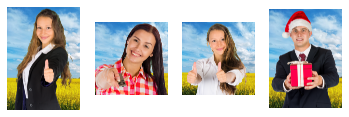

ChromaKeyPlusDespillv2 :
Using the  ChromaKeyPlusDespillv2  method on picture 1 results in an average pixel difference to the ideal result of 3.34 and  87.12 % pixels that could be keyed correctly
Using the  ChromaKeyPlusDespillv2  method on picture 2 results in an average pixel difference to the ideal result of 0.76 and  96.73 % pixels that could be keyed correctly
Using the  ChromaKeyPlusDespillv2  method on picture 3 results in an average pixel difference to the ideal result of 1.75 and  91.52 % pixels that could be keyed correctly
Using the  ChromaKeyPlusDespillv2  method on picture 4 results in an average pixel difference to the ideal result of 0.91 and  95.3 % pixels that could be keyed correctly


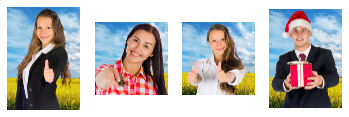

ChromaKeyVersion1a :
Using the  ChromaKeyVersion1a  method on picture 1 results in an average pixel difference to the ideal result of 3.04 and  87.46 % pixels that could be keyed correctly
Using the  ChromaKeyVersion1a  method on picture 2 results in an average pixel difference to the ideal result of 0.76 and  96.73 % pixels that could be keyed correctly
Using the  ChromaKeyVersion1a  method on picture 3 results in an average pixel difference to the ideal result of 1.67 and  91.53 % pixels that could be keyed correctly
Using the  ChromaKeyVersion1a  method on picture 4 results in an average pixel difference to the ideal result of 0.81 and  95.38 % pixels that could be keyed correctly


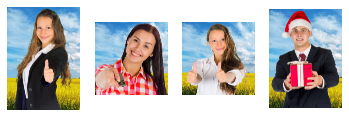

ChromaKeyVersion2 :
Using the  ChromaKeyVersion2  method on picture 1 results in an average pixel difference to the ideal result of 2.59 and  87.67 % pixels that could be keyed correctly
Using the  ChromaKeyVersion2  method on picture 2 results in an average pixel difference to the ideal result of 0.76 and  96.73 % pixels that could be keyed correctly
Using the  ChromaKeyVersion2  method on picture 3 results in an average pixel difference to the ideal result of 1.57 and  91.52 % pixels that could be keyed correctly
Using the  ChromaKeyVersion2  method on picture 4 results in an average pixel difference to the ideal result of 0.81 and  95.38 % pixels that could be keyed correctly


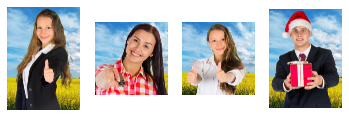

ChromaKeyVersion3 :
Using the  ChromaKeyVersion3  method on picture 1 results in an average pixel difference to the ideal result of 6.33 and  83.2 % pixels that could be keyed correctly
Using the  ChromaKeyVersion3  method on picture 2 results in an average pixel difference to the ideal result of 21.36 and  72.73 % pixels that could be keyed correctly
Using the  ChromaKeyVersion3  method on picture 3 results in an average pixel difference to the ideal result of 6.27 and  85.82 % pixels that could be keyed correctly
Using the  ChromaKeyVersion3  method on picture 4 results in an average pixel difference to the ideal result of 11.9 and  86.0 % pixels that could be keyed correctly


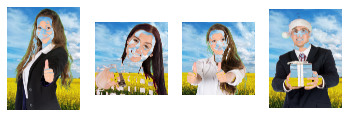

ColorKey :
Using the  ColorKey  method on picture 1 results in an average pixel difference to the ideal result of 2.68 and  87.53 % pixels that could be keyed correctly
Using the  ColorKey  method on picture 2 results in an average pixel difference to the ideal result of 0.75 and  96.74 % pixels that could be keyed correctly
Using the  ColorKey  method on picture 3 results in an average pixel difference to the ideal result of 1.57 and  91.5 % pixels that could be keyed correctly
Using the  ColorKey  method on picture 4 results in an average pixel difference to the ideal result of 0.83 and  95.36 % pixels that could be keyed correctly


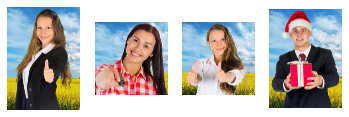

ColorKeyv2 :
Using the  ColorKeyv2  method on picture 1 results in an average pixel difference to the ideal result of 8.42 and  49.16 % pixels that could be keyed correctly
Using the  ColorKeyv2  method on picture 2 results in an average pixel difference to the ideal result of 5.37 and  65.64 % pixels that could be keyed correctly
Using the  ColorKeyv2  method on picture 3 results in an average pixel difference to the ideal result of 7.3 and  49.39 % pixels that could be keyed correctly
Using the  ColorKeyv2  method on picture 4 results in an average pixel difference to the ideal result of 5.42 and  58.39 % pixels that could be keyed correctly


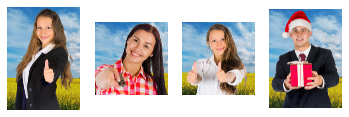

In [98]:
#compare performance of all keying methods that use green-screen by testing four pictures
#
# picture sources:
# https://www.publicdomainpictures.net/en/view-image.php?image=283138&picture=businesswoman-with-thumbs-up
# https://www.publicdomainpictures.net/en/view-image.php?image=363288&picture=woman-with-a-remote-control
# https://www.publicdomainpictures.net/en/view-image.php?image=283134&picture=businesswoman-with-thumbs-up
# https://www.publicdomainpictures.net/en/view-image.php?image=309804&picture=christmas-businessman
#
# background: 
# https://unsplash.com/photos/fJQSCxB18wE


import numpy as np
import datetime, time
import sys
import cv2
import matplotlib.pyplot as plt
import dis



#load test-images and ideal results
original1 = cv2.imread("tests/testpicture1greenbg.png")
result1 = cv2.imread("tests/testpicture1result.png")

original2 = cv2.imread("tests/testpicture2greenbg.png")
result2 = cv2.imread("tests/testpicture2result.png")

original3 = cv2.imread("tests/testpicture3greenbg.png")
result3 = cv2.imread("tests/testpicture3result.png")

original4 = cv2.imread("tests/testpicture4greenbg.png")
result4 = cv2.imread("tests/testpicture4result.png")


#put functions and images into lists
algorithmlist=[ChromaKeyPlusDespill,ChromaKeyPlusDespillv2,ChromaKeyVersion1a,ChromaKeyVersion2,ChromaKeyVersion3,ColorKey,ColorKeyv2]
imagelist=[original1,original2,original3,original4]
resultlist=[result1,result2,result3,result4]

#smaller version of background image
alternate_background0= cv2.imread("tests/vitaliy-gavrushchenko-fJQSCxB18wE-unsplash-3.jpg")

#iterate over every algorithm that uses a greenscreen
for keyingmethod in algorithmlist:
    
    print(keyingmethod.__name__, ":")
    
    #iterate over all 4 test-images
    for i in range (0, len(imagelist)):
        
        #set current input and expected output
        frame=imagelist[i]
        result=resultlist[i]
        
        #update shape
        width, height, channels = frame.shape
        
        #fit background to new shape
        alternate_background= alternate_background0[0:width,0:height]
        
        #reset variables
        saveframes=False
        framecounter=0
        framenumber=0    
        distances2=np.zeros((width,height,3), np.uint8)
        
        #make empty mask with same size as frame
        mask= np.zeros((width,height), np.uint8)
    
        #array that returns the result
        resultimage= np.zeros((width,height,3), np.uint8)

        #read current frame
        frame=keyingmethod(frame)
        
        #copy actual result and expected result to calculate outside of uint8
        framecopy= np.zeros((width,height,3))
        framecopy[:,:,:]=frame[:,:,:]
        resultcopy= np.zeros((width,height,3))
        resultcopy[:,:,:]=result[:,:,:]
        
        #save difference of color of every pixel to expected color
        dif=abs(framecopy-resultcopy)
        
        #plot result
        plt.subplot(1, 4, i+1)
        plot = plt.imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        plt.axis('off')
        
        #calculate mean of dif
        meanframe=np.mean(dif)
        
        correct_pixels_tolerance=3
        correct_pixels_matrix=np.where(dif<=correct_pixels_tolerance,1,0)
        correct_pixels=np.sum(correct_pixels_matrix)
        correct_pixels_percent= (correct_pixels/(width*height*3))*100 
        
        print("Using the ", keyingmethod.__name__, " method on picture", i+1, "results in an average pixel difference to the ideal result of", round(meanframe,2), "and ",round(correct_pixels_percent,2), "% pixels that could be keyed correctly" )
    plt.show()#plot all pictures for current method

    

LumaKey :
Using the  LumaKey  method on picture 1 results in an average pixel difference to the ideal result of 46.14 and  45.04 % pixels that could be keyed correctly
Using the  LumaKey  method on picture 2 results in an average pixel difference to the ideal result of 43.02 and  42.12 % pixels that could be keyed correctly
Using the  LumaKey  method on picture 3 results in an average pixel difference to the ideal result of 47.86 and  39.58 % pixels that could be keyed correctly
Using the  LumaKey  method on picture 4 results in an average pixel difference to the ideal result of 41.7 and  49.4 % pixels that could be keyed correctly


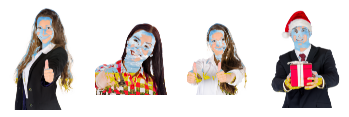

LumaKeyv2 :
Using the  LumaKeyv2  method on picture 1 results in an average pixel difference to the ideal result of 3.49 and  85.99 % pixels that could be keyed correctly
Using the  LumaKeyv2  method on picture 2 results in an average pixel difference to the ideal result of 2.57 and  95.63 % pixels that could be keyed correctly
Using the  LumaKeyv2  method on picture 3 results in an average pixel difference to the ideal result of 12.62 and  82.03 % pixels that could be keyed correctly
Using the  LumaKeyv2  method on picture 4 results in an average pixel difference to the ideal result of 3.45 and  91.39 % pixels that could be keyed correctly


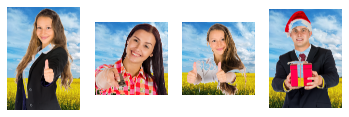

LumaKeyv3 :
Using the  LumaKeyv3  method on picture 1 results in an average pixel difference to the ideal result of 3.84 and  87.25 % pixels that could be keyed correctly
Using the  LumaKeyv3  method on picture 2 results in an average pixel difference to the ideal result of 2.53 and  95.99 % pixels that could be keyed correctly
Using the  LumaKeyv3  method on picture 3 results in an average pixel difference to the ideal result of 2.56 and  90.98 % pixels that could be keyed correctly
Using the  LumaKeyv3  method on picture 4 results in an average pixel difference to the ideal result of 3.6 and  93.47 % pixels that could be keyed correctly


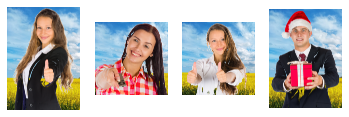

In [99]:
#compare performance of all keying methods that use the luminance by testing four pictures
#
# picture sources:
# https://www.publicdomainpictures.net/en/view-image.php?image=283138&picture=businesswoman-with-thumbs-up
# https://www.publicdomainpictures.net/en/view-image.php?image=363288&picture=woman-with-a-remote-control
# https://www.publicdomainpictures.net/en/view-image.php?image=283134&picture=businesswoman-with-thumbs-up
# https://www.publicdomainpictures.net/en/view-image.php?image=309804&picture=christmas-businessman
#
# background: 
# https://unsplash.com/photos/fJQSCxB18wE

#load test-images and ideal results
whitebg1 = cv2.imread("tests/testpicture1whitebg.png")
blackbg1 = cv2.imread("tests/testpicture1blackbg.png")
result1 = cv2.imread("tests/testpicture1result.png")

whitebg2 = cv2.imread("tests/testpicture2whitebg.png")
blackbg2= cv2.imread("tests/testpicture2blackbg.png")
result2 = cv2.imread("tests/testpicture2result.png")

whitebg3 = cv2.imread("tests/testpicture3whitebg.png")
blackbg3 = cv2.imread("tests/testpicture3blackbg.png")
result3 = cv2.imread("tests/testpicture3result.png")

whitebg4 = cv2.imread("tests/testpicture4whitebg.png")
blackbg4 = cv2.imread("tests/testpicture4blackbg.png")
result4 = cv2.imread("tests/testpicture4result.png")


#put functions and images into lists
algorithmlist_luminance=[LumaKey,LumaKeyv2,LumaKeyv3]
imagelist_white=[whitebg1,whitebg2,whitebg3,whitebg4]
imagelist_black=[blackbg1,blackbg2,blackbg3,blackbg4]

#iterate over every version of luma key
for keyingmethod in algorithmlist_luminance:
    
    print(keyingmethod.__name__, ":")
    
    #iterate over all 4 test-images
    for i in range (0, len(imagelist_white)):
        #set current input and expected output
        frame=imagelist_white[i]
        result=resultlist[i]
        
        #update shape
        width, height, channels = frame.shape
        
        #fit background to new shape
        alternate_background= alternate_background0[0:width,0:height]
        
        #reset variables
        saveframes=False
        framecounter=0
        framenumber=0  
        distances2=np.zeros((width,height,3), np.uint8)
        
    
        #make empty mask with same size as frame
        mask= np.zeros((width,height), np.uint8)
    
        #array that returns the result
        resultimage= np.zeros((width,height,3), np.uint8)

        #read current frame
        frame=keyingmethod(frame)
        
        #copy actual result and expected result to calculate outside of uint8
        framecopy= np.zeros((width,height,3))
        framecopy[:,:,:]=frame[:,:,:]
        resultcopy= np.zeros((width,height,3))
        resultcopy[:,:,:]=result[:,:,:]
        
        #save difference of color of every pixel to expected color
        dif=abs(framecopy-resultcopy)
        
        #plot result
        plt.subplot(1, 4, i+1)
        plot = plt.imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        plt.axis('off')
        
        #calculate mean of dif
        meanframe=np.mean(dif)
        
        correct_pixels_tolerance=3
        correct_pixels_matrix=np.where(dif<=correct_pixels_tolerance,1,0)
        correct_pixels=np.sum(correct_pixels_matrix)
        correct_pixels_percent= (correct_pixels/(width*height*3))*100 
        
        print("Using the ", keyingmethod.__name__, " method on picture", i+1, "results in an average pixel difference to the ideal result of", round(meanframe,2), "and ",round(correct_pixels_percent,2), "% pixels that could be keyed correctly" )
    plt.show()#show all results of current method




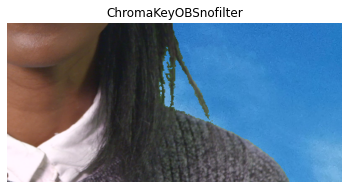

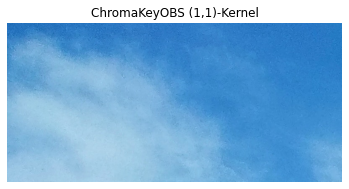

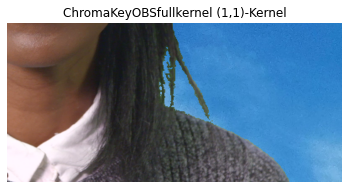

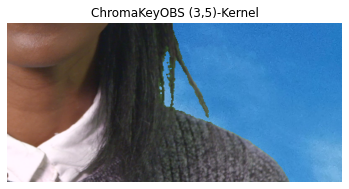

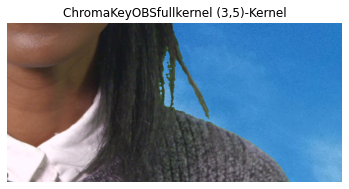

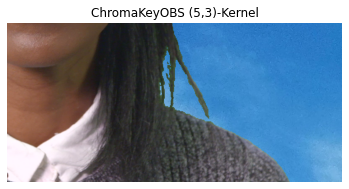

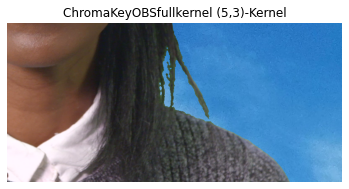

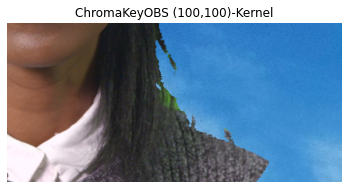

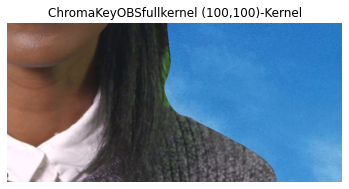

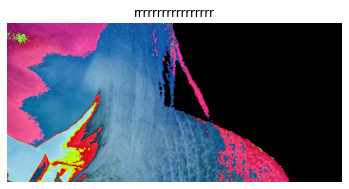

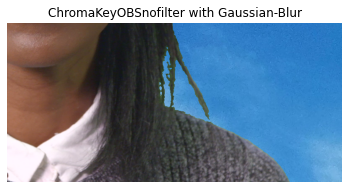

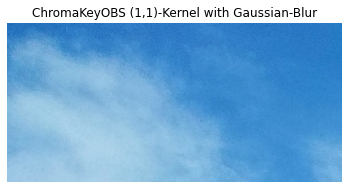

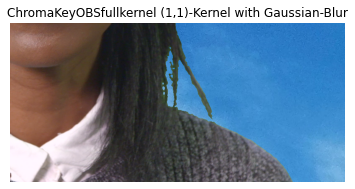

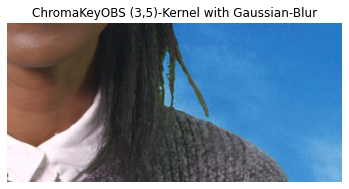

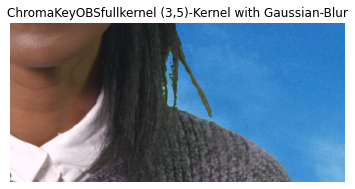

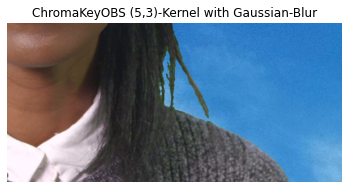

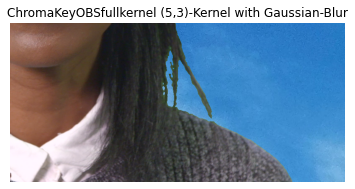

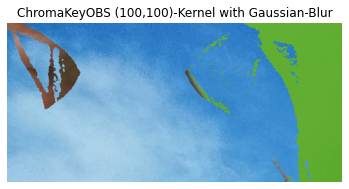

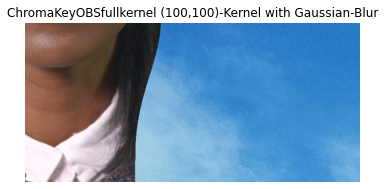

In [34]:
# tests out filter-types and -sizes in ChromaKey1a
#
#

import numpy as np
import datetime, time
import sys
import cv2
import matplotlib.pyplot as plt


#change to False to turn of video
showvideo=True



#cap = cv2.VideoCapture("171003D_017_2K.mp4") 
cap = cv2.VideoCapture("171003B_005_2K.mp4") 
#cap = cv2.VideoCapture(0)




#source:https://unsplash.com/photos/fJQSCxB18wE
alternate_background= cv2.imread("vitaliy-gavrushchenko-fJQSCxB18wE-unsplash.jpg")
#alternate_background= cv2.imread("white.png")




rval, frame = cap.read()
height,width, channels = frame.shape
#resize background to frame
#alternate_background = cv2.resize(alternate_background, (width,height))

saveframes=False
framecounter=0
distances2=np.zeros((height,width,3), np.uint8)
framenumber=0

#todo
mean=0

counter=2
counterprev=1 
#initialize array for saving current mean of all frames
meanimage=np.zeros((height,width,3), np.uint8)
framecopy=np.zeros((height,width,3))
#make copy of meanimage for calculations outside of rgb color space
meanimagecopy=np.zeros((height,width,3))
#initialize meanimage with first frame
meanimage=frame




def ChromaKeyOBS(frame4,pixel,pixel_h,gauss):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    #green RGB(0,255,0)
    colorbase=np.array([0,200,0])
    
    #convert base color to yuv
    chroma_key=cv2.cvtColor( np.uint8([[colorbase]] ), cv2.COLOR_RGB2YUV)[0][0]
    
    
    
    #frame4[:,:,:]=np.minimum(255,2*(np.maximum(0,frame4[:,:,:]-((1/2)*chroma_key))))
    
    
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key[0]),float(chroma_key[1]),float(chroma_key[2])])

    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy u and v chanel for calculating distance outside of uint8
    yuv_u=np.zeros((width,height))
    yuv_u[:,:]=yuv[:,:,1]
    yuv_v=np.zeros((width,height))
    yuv_v[:,:]=yuv[:,:,2]
    
    #calculate distances
    distances=((chroma_key2[1]-yuv_u)**2+(chroma_key2[2]-yuv_v)**2)**(0.5)
       

    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[0,0],kernel[pixel-1,0],kernel[pixel-1,pixel_h-1],kernel[0,pixel_h-1]=2/9,2/9,2/9,2/9
    kernel[int((pixel-1)/2),int((pixel_h-1)/2)]=1/9
    
    
    #apply kernel on distances
    distances=cv2.filter2D(distances,-1, kernel)
    
    if(gauss==True):
        distances=cv2.GaussianBlur(distances, (3, 3), 0)
    
   
    #assign pixels with distances<threshold to foreground and >=threshold to foreground
    threshold1=100
    threshold2=160
    distances= np.where(distances<threshold1,0,1)
    #distances= np.where(((distances-threshold1)/(threshold2/threshold1))<=0,0, np.where(((distances-threshold1)/(threshold2/threshold1))>=1,1, 3*((distances-threshold1)/(threshold2/threshold1))**2- 2*((distances-threshold1)/(threshold2/threshold1))**3))

    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    
    return(resultimage)



def ChromaKeyOBSnofilter(frame4,pixel,pixel_h,gauss):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    #green RGB(0,255,0)
    colorbase=np.array([0,200,0])
    
    #convert base color to yuv
    chroma_key=cv2.cvtColor( np.uint8([[colorbase]] ), cv2.COLOR_RGB2YUV)[0][0]
    
    
    
    #frame4[:,:,:]=np.minimum(255,2*(np.maximum(0,frame4[:,:,:]-((1/2)*chroma_key))))
    
    
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key[0]),float(chroma_key[1]),float(chroma_key[2])])

    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy u and v chanel for calculating distance outside of uint8
    yuv_u=np.zeros((width,height))
    yuv_u[:,:]=yuv[:,:,1]
    yuv_v=np.zeros((width,height))
    yuv_v[:,:]=yuv[:,:,2]
    
    #calculate distances
    distances=((chroma_key2[1]-yuv_u)**2+(chroma_key2[2]-yuv_v)**2)**(0.5)
    
    
    if(gauss==True):
        distances=cv2.GaussianBlur(distances, (3, 3), 0)
    
    
    #assign pixels with distances<threshold to foreground and >=threshold to foreground
    threshold1=100
    threshold2=160
    distances= np.where(distances<threshold1,0,1)
    #distances= np.where(((distances-threshold1)/(threshold2/threshold1))<=0,0, np.where(((distances-threshold1)/(threshold2/threshold1))>=1,1, 3*((distances-threshold1)/(threshold2/threshold1))**2- 2*((distances-threshold1)/(threshold2/threshold1))**3))

    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    
    return(resultimage)





def ChromaKeyOBSfullkernel(frame4,pixel,pixel_h,gauss):
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)

    #convert every pixel in frame from rgb to yuv
    yuv = cv2.cvtColor(frame4, cv2.COLOR_RGB2YUV)
    
    #green RGB(0,255,0)
    colorbase=np.array([0,200,0])
    
    #convert base color to yuv
    chroma_key=cv2.cvtColor( np.uint8([[colorbase]] ), cv2.COLOR_RGB2YUV)[0][0]
    
    
    
    #frame4[:,:,:]=np.minimum(255,2*(np.maximum(0,frame4[:,:,:]-((1/2)*chroma_key))))
    
    
    
    #make copy of chroma_key for calculations outside of uint8
    chroma_key2=np.array([float(chroma_key[0]),float(chroma_key[1]),float(chroma_key[2])])

    
    #array that saves the euclidean distance between all pixels in current frame and chroma key
    distances=np.zeros((width,height))
    
    #copy u and v chanel for calculating distance outside of uint8
    yuv_u=np.zeros((width,height))
    yuv_u[:,:]=yuv[:,:,1]
    yuv_v=np.zeros((width,height))
    yuv_v[:,:]=yuv[:,:,2]
    
    #calculate distances
    distances=((chroma_key2[1]-yuv_u)**2+(chroma_key2[2]-yuv_v)**2)**(0.5)
       

    
    #fill kernel     (kernel=np.array([[2,0,0,0,2],[0,0,1,0,0],[2,0,0,0,2]])/9)
    kernel=np.zeros((pixel,pixel_h))     
    kernel[:,:]=1/(pixel*pixel_h)
    
    
    #apply kernel on distances
    distances=cv2.filter2D(distances,-1, kernel)
    
    
    
    if(gauss==True):
        distances=cv2.GaussianBlur(distances, (5, 5), -1)
    
   
    #assign pixels with distances<threshold to foreground and >=threshold to foreground
    threshold1=100
    threshold2=160
    distances= np.where(distances<threshold1,0,1)
    #distances= np.where(((distances-threshold1)/(threshold2/threshold1))<=0,0, np.where(((distances-threshold1)/(threshold2/threshold1))>=1,1, 3*((distances-threshold1)/(threshold2/threshold1))**2- 2*((distances-threshold1)/(threshold2/threshold1))**3))

    resultimage[:,:,0]=((distances[:,:])*frame4[:,:,0])+((1-distances[:,:])*alternate_background[:,:,0])
    resultimage[:,:,1]=((distances[:,:])*frame4[:,:,1])+((1-distances[:,:])*alternate_background[:,:,1])
    resultimage[:,:,2]=((distances[:,:])*frame4[:,:,2])+((1-distances[:,:])*alternate_background[:,:,2])
    
    return(resultimage)







while(showvideo):
    #read current frame
    rval, frame4 = cap.read()
    
    
    #frame4=cv2.imread("engin-akyurt-d9Rit-GWBoI-unsplash-2.jpg")
    frame4=frame4[700:1700,900:1700]
    
    #shape of frame
    width, height, channels = frame4.shape
    
    alternate_background= alternate_background[0:width,0:height]
    
    #make empty mask with same size as frame
    mask= np.zeros((width,height), np.uint8)
    
    #array that returns the result
    resultimage= np.zeros((width,height,3), np.uint8)
    
    #show original frame
    #cv2.imshow('original',frame4)
    
    
        
    
    
    #return result of current frame
    #for i in range(10000,10001):

    
    #cv2.imshow('ChromaKeyOBS (1,1)-Kernel'+str(1),ChromaKeyOBS(frame4,1,1,False))
    #cv2.imshow('ChromaKeyOBSfullkernel (1,1)-Kernel'+str(1),ChromaKeyOBSfullkernel(frame4,1,1,False))
    #cv2.imshow('ChromaKeyOBSnofilter'+str(1),ChromaKeyOBSnofilter(frame4,False))
    
    #cv2.imshow('ChromaKeyOBS (3,5)-Kernel'+str(1),ChromaKeyOBS(frame4,3,5,False))
    #cv2.imshow('ChromaKeyOBSfullkernel (3,5)-Kernel'+str(1),ChromaKeyOBSfullkernel(frame4,3,5,False))
    
    #cv2.imshow('ChromaKeyOBS (5,3)-Kernel'+str(1),ChromaKeyOBS(frame4,5,3,False))
    #cv2.imshow('ChromaKeyOBSfullkernel (5,3)-Kernel'+str(1),ChromaKeyOBSfullkernel(frame4,5,3,False))
    
    #cv2.imshow('ChromaKeyOBS (1000,1000)-Kernel'+str(1),ChromaKeyOBS(frame4,1000,1000,False))
    #cv2.imshow('ChromaKeyOBSfullkernel (1000,1000)-Kernel'+str(1),ChromaKeyOBSfullkernel(frame4,1000,1000,False))
    
    
    #cv2.imshow('ChromaKeyOBS (1,1)-Kernel with Gaussian-Blur'+str(1),ChromaKeyOBS(frame4,1,1,True))
    #cv2.imshow('ChromaKeyOBSfullkernel (1,1)-Kernel with Gaussian-Blur'+str(1),ChromaKeyOBSfullkernel(frame4,1,1,True))
    #cv2.imshow('ChromaKeyOBSnofilter with Gaussian-Blur'+str(1),ChromaKeyOBSnofilter(frame4,True))
    
    #cv2.imshow('ChromaKeyOBS (3,5)-Kernel with Gaussian-Blur'+str(1),ChromaKeyOBS(frame4,3,5,True))
    #cv2.imshow('ChromaKeyOBSfullkernel (3,5)-Kernel with Gaussian-Blur'+str(1),ChromaKeyOBSfullkernel(frame4,3,5,True))
    
    #cv2.imshow('ChromaKeyOBS (5,3)-Kernel with Gaussian-Blur'+str(1),ChromaKeyOBS(frame4,5,3,True))
    #cv2.imshow('ChromaKeyOBSfullkernel (5,3)-Kernel with Gaussian-Blur'+str(1),ChromaKeyOBSfullkernel(frame4,5,3,True))
    
    #cv2.imshow('ChromaKeyOBS (1000,1000)-Kernel with Gaussian-Blur'+str(1),ChromaKeyOBS(frame4,1000,1000,True))
    #cv2.imshow('ChromaKeyOBSfullkernel (1000,1000)-Kernel with Gaussian-Blur'+str(1),ChromaKeyOBSfullkernel(frame4,1000,1000,True))
    
    
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBSnofilter(frame4,1,1,False), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBSnofilter")
    plt.axis('off')
    plt.show()
    
    
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBS(frame4,1,1,False), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBS (1,1)-Kernel")
    plt.axis('off')
    plt.show()
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBSfullkernel(frame4,1,1,False), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBSfullkernel (1,1)-Kernel")
    plt.axis('off')
    plt.show()
    
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBS(frame4,3,5,False), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBS (3,5)-Kernel")
    plt.axis('off')
    plt.show()
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBSfullkernel(frame4,3,5,False), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBSfullkernel (3,5)-Kernel")
    plt.axis('off')
    plt.show()
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBS(frame4,5,3,False), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBS (5,3)-Kernel")
    plt.axis('off')
    plt.show()
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBSfullkernel(frame4,5,3,False), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBSfullkernel (5,3)-Kernel")
    plt.axis('off')
    plt.show()
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBS(frame4,100,100,False), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBS (100,100)-Kernel")
    plt.axis('off')
    plt.show()
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBSfullkernel(frame4,100,100,False), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBSfullkernel (100,100)-Kernel")
    plt.axis('off')
    plt.show()
    
    
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBSnofilter(frame4,1,1,True), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBSnofilter with Gaussian-Blur")
    plt.axis('off')
    plt.show()
    
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBS(frame4,1,1,True), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBS (1,1)-Kernel with Gaussian-Blur")
    plt.axis('off')
    plt.show()
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBSfullkernel(frame4,1,1,True), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBSfullkernel (1,1)-Kernel with Gaussian-Blur")
    plt.axis('off')
    plt.show()
    
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBS(frame4,3,5,True), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBS (3,5)-Kernel with Gaussian-Blur")
    plt.axis('off')
    plt.show()
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBSfullkernel(frame4,3,5,True), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBSfullkernel (3,5)-Kernel with Gaussian-Blur")
    plt.axis('off')
    plt.show()
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBS(frame4,5,3,True), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBS (5,3)-Kernel with Gaussian-Blur")
    plt.axis('off')
    plt.show()
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBSfullkernel(frame4,5,3,True), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBSfullkernel (5,3)-Kernel with Gaussian-Blur")
    plt.axis('off')
    plt.show()
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBS(frame4,1000,1000,True), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBS (100,100)-Kernel with Gaussian-Blur")
    plt.axis('off')
    plt.show()
    
    plot = plt.imshow(cv2.cvtColor(ChromaKeyOBSfullkernel(frame4,1000,1000,True), cv2.COLOR_RGB2BGR))
    plt.title("ChromaKeyOBSfullkernel (100,100)-Kernel with Gaussian-Blur")
    plt.axis('off')
    plt.show()
    
    break
    #close window if esc is pressed
    key = cv2.waitKey(1)
    if key == 27: 
        break

cv2.destroyAllWindows()


